In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

from xgboost import XGBClassifier


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')


In [3]:
train.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [20]:
train.shape

(593994, 13)

In [6]:
# Fill missing values in target column (if any)
train['loan_paid_back'] = train['loan_paid_back'].fillna(
    train['loan_paid_back'].mode()[0]
)

# Numeric columns
num_cols = [
    'annual_income',
    'debt_to_income_ratio',
    'credit_score',
    'loan_amount',
    'interest_rate'
]

for col in num_cols:
    train[col] = train[col].fillna(train[col].median())

# Categorical columns
cat_cols = [
    'gender',
    'marital_status',
    'education_level',
    'employment_status',
    'loan_purpose',
    'grade_subgrade'
]

for col in cat_cols:
    train[col] = train[col].fillna(train[col].mode()[0])


In [7]:
train.isnull().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

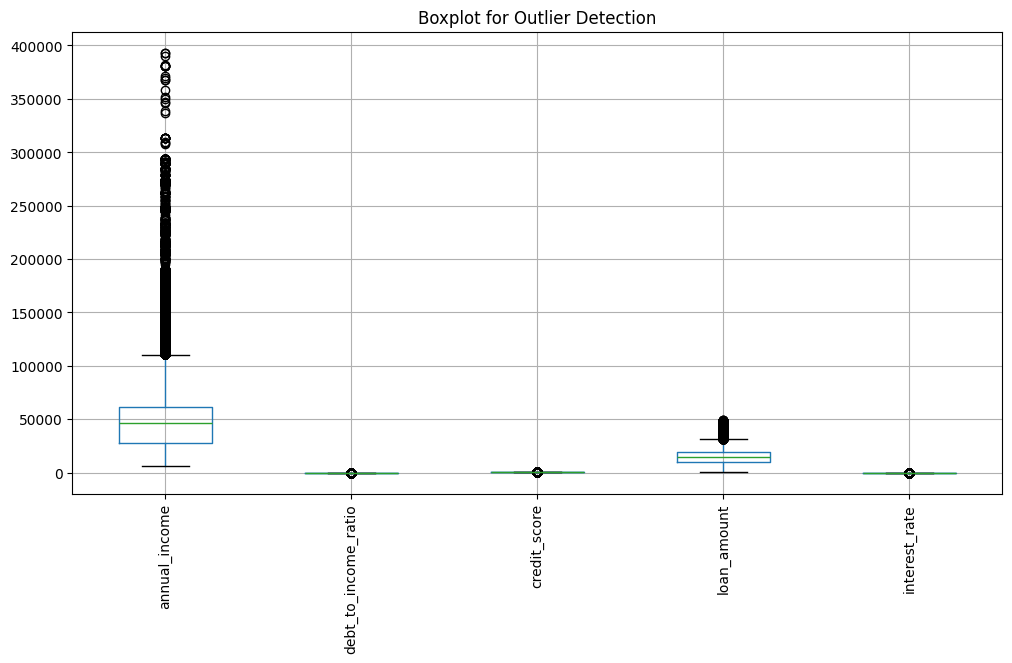

In [8]:
plt.figure(figsize=(12,6))
train[num_cols].boxplot(rot=90)
plt.title("Boxplot for Outlier Detection")
plt.show()


In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in cat_cols:
    train[col] = le.fit_transform(train[col])

In [10]:
for col in num_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    train[col] = np.clip(train[col], lower, upper)


In [11]:
le = LabelEncoder()
train['loan_paid_back'] = le.fit_transform(train['loan_paid_back'])

X = train.drop("loan_paid_back", axis=1)
y = train['loan_paid_back']


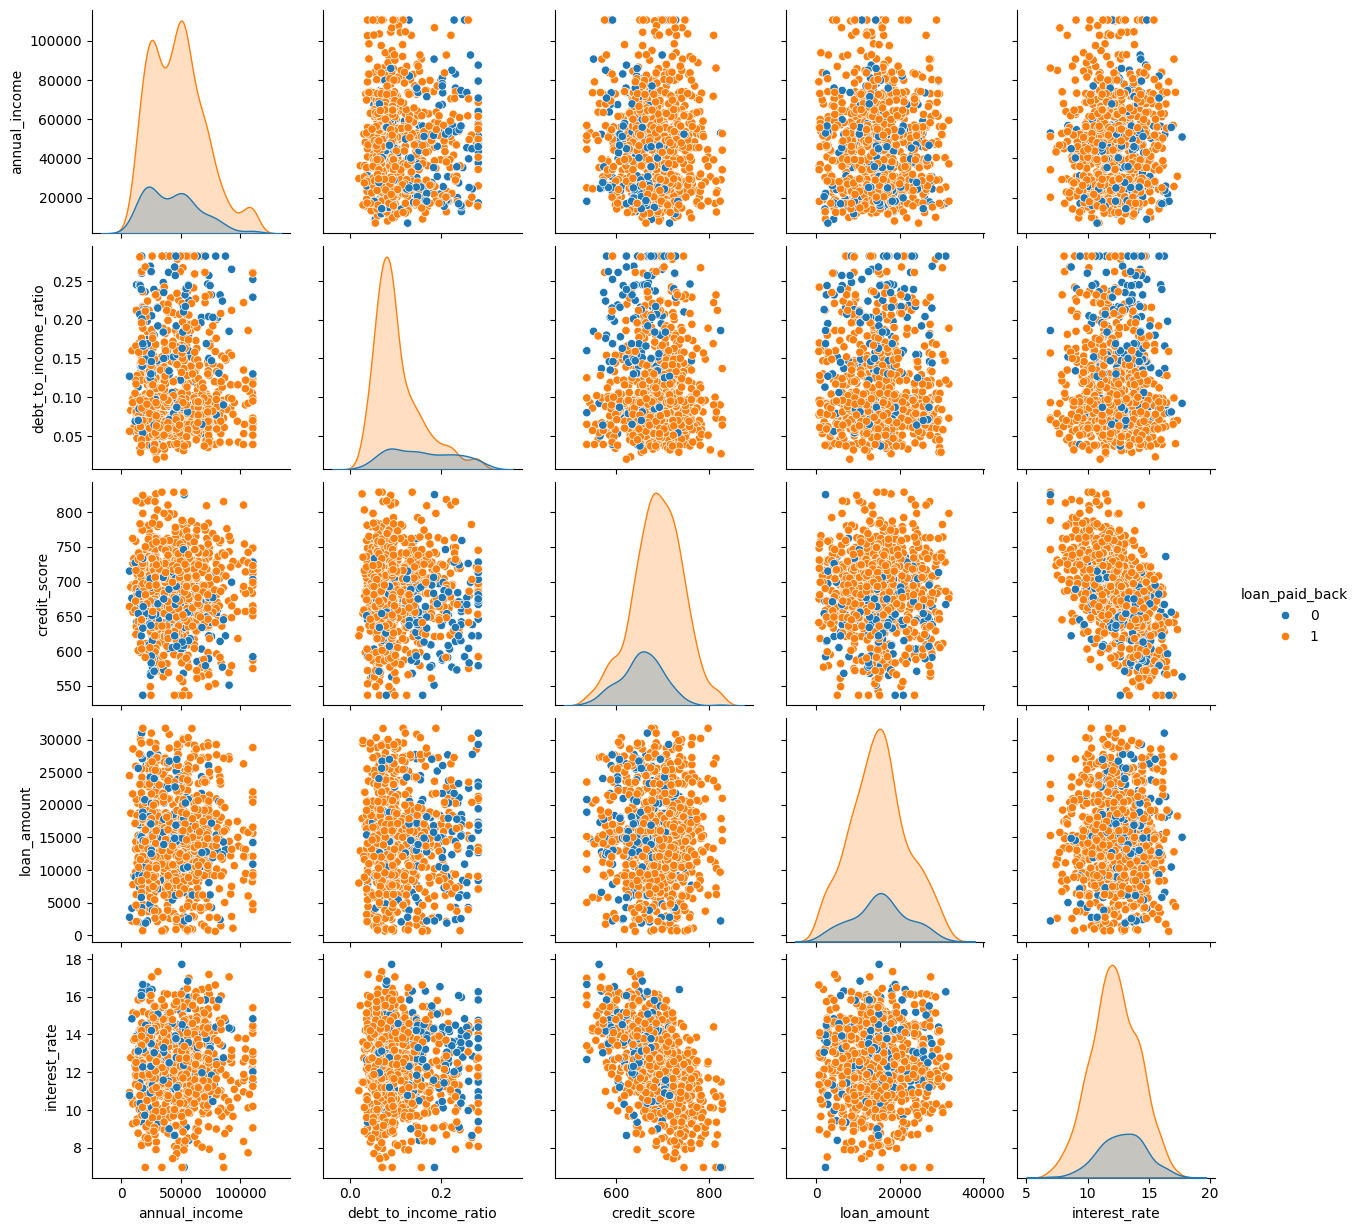

In [13]:

import seaborn as sns
sns.pairplot(train.sample(1000), vars=num_cols, hue='loan_paid_back')



In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [22]:
param_dist = {
    'n_estimators': [200, 300, 400],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0, 0.1],
    'min_child_weight': [1, 3]
}

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',     # 🔥 FAST for large datasets
    random_state=42,
    n_jobs=-1
)
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,              # 🔥 20 → 10 (enough)
    scoring='roc_auc',      # better than accuracy
    cv=2,                   # 🔥 faster
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)


Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}


In [24]:
y_pred = best_model.predict(X_val_scaled)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))


Validation Accuracy: 0.903574094130719


In [25]:


# probability of positive class (class = 1)
y_proba = best_model.predict_proba(X_val_scaled)[:, 1]

roc_auc = roc_auc_score(y_val, y_proba)

print("Binary ROC-AUC:", roc_auc)


Binary ROC-AUC: 0.919911106175657


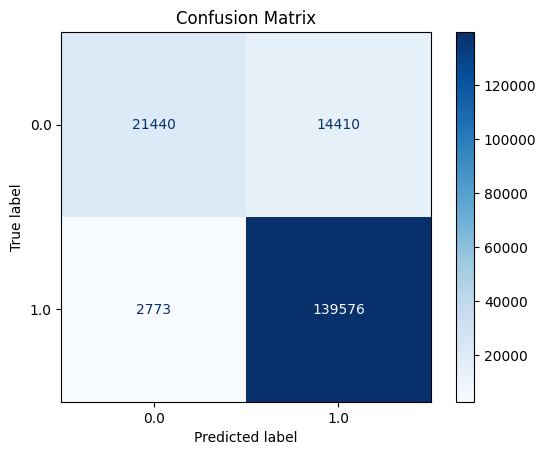

In [26]:
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [31]:
test = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')

test.head()
print(test.columns)

Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'gender', 'marital_status',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade'],
      dtype='object')


In [33]:
num_cols = [
    'annual_income',
    'debt_to_income_ratio',
    'credit_score',
    'loan_amount',
    'interest_rate'
]

for col in num_cols:
    test[col] = test[col].fillna(test[col].median())

# Categorical columns
cat_cols = [
    'gender',
    'marital_status',
    'education_level',
    'employment_status',
    'loan_purpose',
    'grade_subgrade'
]

for col in cat_cols:
    test[col] = test[col].fillna(test[col].mode()[0])


In [34]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in cat_cols:
    test[col] = le.fit_transform(test[col])

In [35]:
test.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,593994,28781.05,0.049,626,11461.42,14.73,0,2,1,0,6,19
1,593995,46626.39,0.093,732,15492.25,12.85,0,1,2,0,6,10
2,593996,54954.89,0.367,611,3796.41,13.29,1,2,0,0,2,15
3,593997,25644.63,0.110,671,6574.30,9.57,0,2,0,0,2,12
4,593998,25169.64,0.081,688,17696.89,12.80,0,1,4,0,0,10


In [36]:
test_ids = test['id']

test_scaled = scaler.transform(test)

test_preds = best_model.predict(test_scaled)
final_preds = le.inverse_transform(test_preds)

In [37]:
submission = pd.DataFrame({
    "id": test_ids,
    "Class": final_preds
})

submission.to_csv("final_multiclass_randomsearch.csv", index=False)
